In [1]:
import pyro
import torch
import wandb
import os

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from inference.bayesian.models import TorchModel, BayesianModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 10, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "svi",
            "lr": 0.03,
            "num_iterations": 500,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# SVI

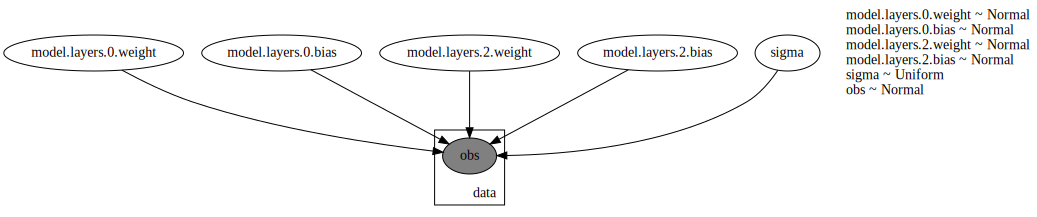

In [5]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

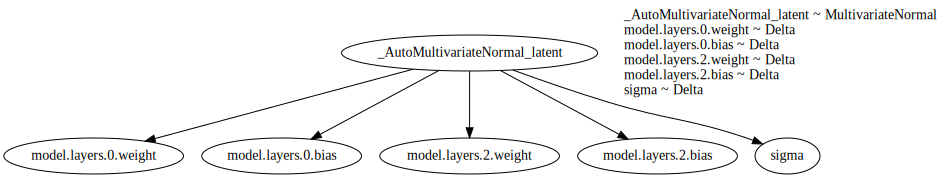

In [6]:
pyro.clear_param_store()

# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)

In [7]:
num_samples = 2000

predictive, diagnostics = inference(config, svi_model, guide, X_train=train_embedding, Y_train=Ytr, 
                                    X_test=test_embedding, Y_test=Yte, num_samples=num_samples, inference_name=None)

Epoch 499: 100%|██████████| 500/500 [00:11<00:00, 43.62it/s, loss=-1.33e+19]


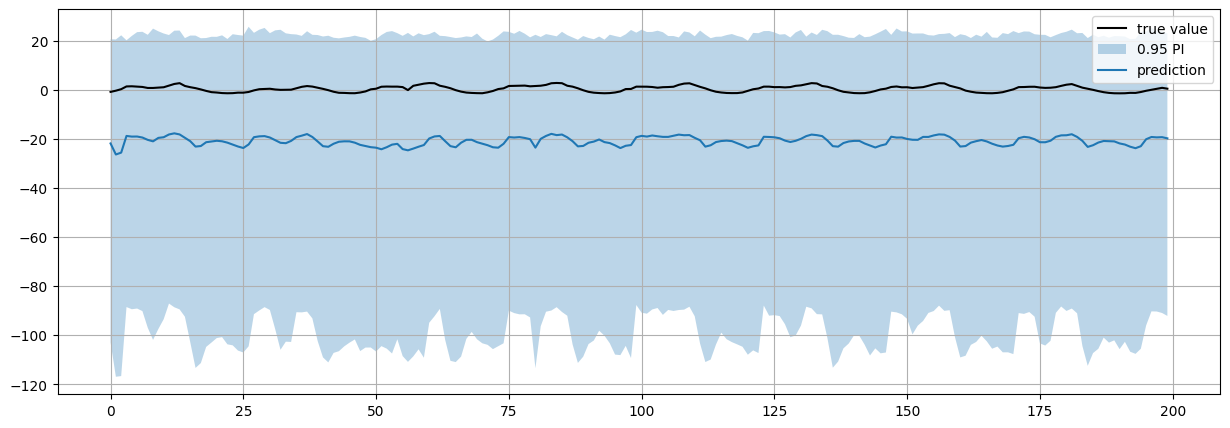

In [8]:
plot_forecast(predictive, Yte, "svi")

In [9]:
for k, v in diagnostics.items():
    print(k)

train_time
quantiles
cal_error
crps


In [9]:
print("training time: ", diagnostics['train_time'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])

training time:  0.125
calibration error:  113.52652029035886
Continuous ranked probability score:  9.770601272583008


In [ ]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')